In [ ]:
# The execution time of this notebook is around 1 hour with a GPU T4
#!pip install tensorflow==2.17.1 # or 2.18.0

### **Introduction**

This notebook cover the model construction and training of an image captioning model using Flickr8k dataset which is used as basel model

The outline is:
1. Loading and processing captions
2. Loading and extracting image features
3. Data generator to prepare input X[i] and target Y[i]
4. Define and train model
5. Visualize model outputs
6. Model evaluation
7. Model conclusions

The model here was desing to be simple using blocks of sequential API

>  The model integrates a pre-trained InceptionV3 CNN as the encoder to extract image features, which are further processed with BatchNormalization, TimeDistributed dense layers, and an LSTM to produce a 256-dimensional feature vector. The decoder uses an Embedding layer and an LSTM to process caption sequences, which are concatenated with repeated image features. The combined features are refined through TimeDistributed dense layers, with the final layer using softmax activation to predict the next word in the sequence. The model is trained using the Adam optimizer and the sparse categorical crossentropy loss function.

More details below

**It's highlight recommended to run this notebook with Colab TPU !!** (take care, some GPUs might cause code incompatibility)

### **Environmnet**

In [2]:
!python --version

Python 3.10.12


In [3]:
import os, re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

tf.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


'2.18.0'

In [2]:
# Common functions
def show_image(path: str):
    try:
        plt.figure(figsize=(15, 15))
        plt.imshow(Image.open(path))
        plt.axis('off')
        plt.show()
    except:
        print("Image not found")

### **Download Dataset**

The dataset is downloaded from GitHub, first we get two .zip file and once extracted contains the images in .jpg format and captions in .txt files. For more details about the dataset, see the notebook 1.

In [6]:
import shutil, zipfile
import requests

# Define paths and URLs
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
captions_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
dataset_dir = "flickr8k_dataset"
captions_file = "Flickr8k.token.txt"

# Create Dataset Directory
os.makedirs(dataset_dir, exist_ok=True)

# Download and Extract Functions
def download_file(url, dest_path):
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    with open(dest_path, "wb") as file:
        shutil.copyfileobj(response.raw, file)
    print(f"File saved to {dest_path}")

def extract_zip(file_path, extract_to):
    print(f"Extracting {file_path}...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to {extract_to}")

# Download images
images_zip_path = os.path.join(dataset_dir, "images.zip")
images_extract_path = os.path.join(dataset_dir, "Flicker8k_Dataset")

if not os.path.exists(images_extract_path):
    download_file(dataset_url, images_zip_path)
    extract_zip(os.path.join(dataset_dir, "images.zip"), dataset_dir)
else:
    print("Images already downloaded")

# Download captions
captions_txt_path = os.path.join(dataset_dir, captions_file)
if not os.path.exists(captions_txt_path):
    download_file(captions_url, os.path.join(dataset_dir, "captions.zip"))
    extract_zip(os.path.join(dataset_dir, "captions.zip"), dataset_dir)
else:
    print("Captions already downloaded")

File saved to flickr8k_dataset/images.zip
Extracting flickr8k_dataset/images.zip...
Extracted to flickr8k_dataset
File saved to flickr8k_dataset/captions.zip
Extracting flickr8k_dataset/captions.zip...
Extracted to flickr8k_dataset


### **Loading Dataset**

The original dataset suggests a default split for training, test and validation. The same split is kept here.

In [7]:
# Paths
dataset_dir = "flickr8k_dataset"

def load_text(filename):
    file = open(filename, 'r')
    text = file.read()
    text = text.split('\n')
    file.close()
    return text

train_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.trainImages.txt"))
test_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.devImages.txt"))

train_imgs = [x for x in train_imgs if x != '']
test_imgs = [x for x in test_imgs if x != '']
dev_imgs = [x for x in dev_imgs if x != '']

print("Number of images in training set: ", len(train_imgs))
print("Number of images in test set: ", len(test_imgs))
print("Number of images in dev set: ", len(dev_imgs))

Number of images in training set:  6000
Number of images in test set:  1000
Number of images in dev set:  1000


### **Training Data Pipeline**

We will build the pipeline for our deep learning architecture in four phases

#### **1. Caption Text Preprocessing**

This phase covers:
* Convert sentences into lowercase
* Remove special characters, numbers present in the text and extra spaces
* Remove words with length to focus on more meaningful, context-rich words
* Add a starting and an ending tag to each caption to helps the model understand where captions begin and end
* Converts words in the caption into numerical tokens using a predefined vocabulary
* Pads all captions to a uniform length to ensure that all captions in a batch have the same length

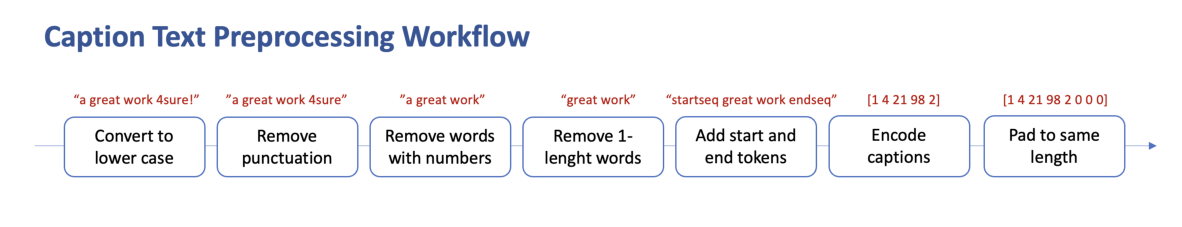

In [4]:
show_image("src/caption_preprocessing.png")

When loading the caption file, the captions are reorganized into a dictionary, where the image id serves as the key and a list of five captions corresponds to the value

In [9]:
# Load Captions
captions_file = "Flickr8k.token.txt"
captions_path = os.path.join(dataset_dir, captions_file)

def load_captions(filepath):
    captions = {}
    with open(filepath, 'r') as f:
        for line in f:
            image_id, caption = line.strip().split('\t')
            image_id = image_id.split('#')[0]
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

captions_dictionary = load_captions(captions_path)
captions_dictionary['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
# Cleaning Captions
def clean_text(text):
    text = " ".join([word.lower() for word in text.split() if len(word) > 1])
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = "startseq " + text + " endseq"
    return text.lower()

for key, captions in captions_dictionary.items():
    for i, caption in enumerate(captions):
        captions[i] = clean_text(caption)

captions_dictionary['1000268201_693b08cb0e.jpg']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

For tokenizing captions and setting the vocabulary size, I rely on Keras's built-in tokenizer, which is easy and fast to use and integrates seamlessly with the Keras ecosystem. Pre-trained word **embedding models** such as GloVe, Word2Vec, or FastText can be used here to capture semantic meaning and relationships between words.

In [11]:
def flatten_captions (data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])

def create_tokenizer(data_dict):
  captions = flatten_captions(data_dict)
  max_caption_words = max(len(caption.split()) for caption in captions)

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(captions)
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_caption_words)

In [12]:
# Fit a Keras tokenizer given caption descriptions
tokenizer, vocab_size, max_caption_words = create_tokenizer(captions_dictionary)

# Display sample
print("Word Index (first 10 words):", dict(list(tokenizer.word_index.items())[:10]))
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_words)

Word Index (first 10 words): {'startseq': 1, 'endseq': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10}
Vocabulary Size: 8774
Maximum Caption Length: 34


#### **2. Images Preprocessing**

This phase cover the extraction of image feature maps using InceptionV3. The reason behind using InceptionV3 as the pre-trained CNN came from identify this model as popular for image captioning problems in the literature.

The convolutional layers in InceptionV3 produce compact, high-dimensional feature maps that summarize the image content. Another significant reason for using a pre-trained model is to reduce training time and improve generalization, as the model has already learned to extract meaningful features.

In [13]:
# list of images
def subset_image_name (filename):
  data = []

  with open(filename, "r") as fp:
    text = fp.read()
    lines = text.split ('\n')
    for line in lines:
      if (len(line) < 1):
        continue
      image_name = line.split ('.')[0]
      data.append (image_name)

    return (set(data))

training_image_name_file = "flickr8k_dataset/Flickr_8k.trainImages.txt"
training_image_names = subset_image_name (training_image_name_file)

To use InceptionV3, first let's prepare the images for input into the InceptionV3 model. Then, creates a new model that takes an image as input and outputs the feature map produced by the last convolutional layer.

I remove the classifier part (the fully connected layers) to isolate extracting features process.

In [14]:
# Preprocesses each image as input for InceptionV3 model
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # default input size for InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Load the InceptionV3 model without classification layer
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Create a new model that outputs feature maps from the convolutional base
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Instead of processing images through InceptionV3 repeatedly during captioning model training, the extracted features are precomputed and stored as .npy files. This idea was taken from liteature, claiming reduction in computation time and memory usage during training. The feature extraction pipeline overview is:

1. Image Paths → Create TensorFlow Dataset
2. Load and Preprocess Images → Using load_image
3. Extract Features → Using image_features_extract_model
4. Save Features → As .npy files for later use

In [15]:
from tqdm import tqdm
import numpy as np

image_dir = "flickr8k_dataset/Flicker8k_Dataset/"
training_image_paths = [image_dir + name + '.jpg' for name in training_image_names]
encode_train = sorted(set(training_image_paths))

# Create batch TensorFlow dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extract features over each dataset and saving
features_dir = "flickr8k_dataset/image_features"
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    os.makedirs(features_dir, exist_ok=True)
    base_name = os.path.basename(p.numpy().decode("utf-8"))
    path_of_feature = os.path.join(features_dir, base_name.replace(".jpg", ".npy"))
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [02:21<00:00,  2.64it/s]


 The .npy files  contain high-level feature maps, not human-readable images. These feature maps represent the abstract features extracted by the model, such as edges, textures, and object parts, which can be visualized as heatmaps or grids.

Feature map has a shape of (64, 2048), it represents 64 spatial locations (flattened grid of height × width) with 2048 channels. To visualize this data, we can reshape it into a 2D spatial grid if we know the dimensions of the feature map.

For InceptionV3, the last convolutional layer outputs a feature map with 8x8 dimension with 2048 channels, so the shape of the feature map for a single image is: (8, 8, 2048).

Feature Map Shape: (64, 2048)
Reshaped Feature Map Shape: (8, 8, 2048)


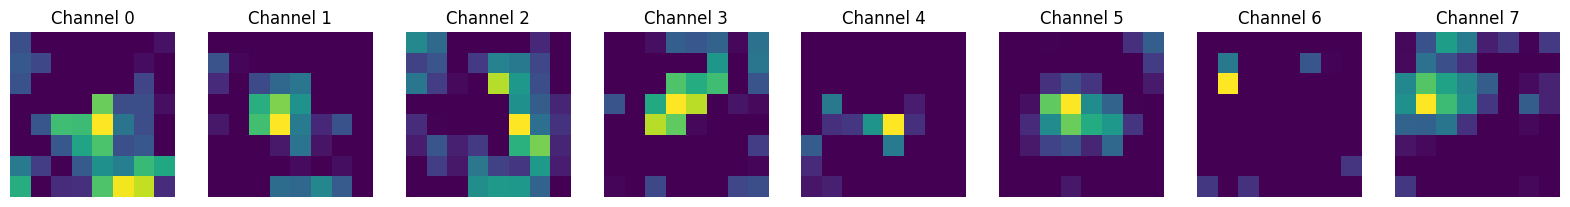

In [16]:
# Load the .npy file
feature_map = np.load("flickr8k_dataset/image_features/667626_18933d713e.npy")

reshaped_feature_map = feature_map.reshape((8, 8, 2048))
print("Feature Map Shape:", feature_map.shape)
print("Reshaped Feature Map Shape:", reshaped_feature_map.shape)


# Visualize multiple channels
num_channels_to_display = 8
fig, axes = plt.subplots(1, num_channels_to_display, figsize=(20, 5))

for i in range(num_channels_to_display):
    ax = axes[i]
    channel_data = reshaped_feature_map[:, :, i]
    channel_data_normalized = (channel_data - channel_data.min()) / (channel_data.max() - channel_data.min())
    ax.imshow(channel_data_normalized, cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Channel {i}")

plt.show()

These feature maps show the activation patterns of individual filters (channels) in the last convolutional layer. Yellow areas in the feature maps indicate strong activations for that filter, meaning that the filter has identified a feature of interest in that region while dark purple areas represent low or no activations. These maps provide insights into the network's internal representation of the image, helping us understand what it "sees."

#### **3. Data Setup for Model Input**

Pre-processed captions and images is done, now let's setup the input data for the model as following:

* A train_X array consists of file paths
* A train_y array contains properly padded captions, ready for the model
* The tf.data.Dataset pipeline ensures efficient data loading, shuffling, batching, and prefetching

First, let's go through every training image and its matching captions to prepare the training data

In [17]:
# Returns the subset of the data dictionary given the image names
def subset_data_dict (captions_dictionary, image_names):
  dict = { image_name:captions for image_name, captions in captions_dictionary.items() if image_name in image_names}
  return (dict)

training_dict = subset_data_dict (captions_dictionary, train_imgs)
print("Number of images in training set: ", len(training_dict))

Number of images in training set:  6000


Now let's converts image paths (X) and padded captions (y) into NumPy arrays to align with your subsequent TensorFlow Dataset setup. As this function is very critical I decided to document it properly.

In [18]:
def data_prep(captions_dictionary, tokenizer, max_length, image_feature_dir):
    """
    Prepare the training data as NumPy arrays for TensorFlow Dataset.

    Args:
        captions_dictionary (dict): A dictionary where keys are image file names and values are lists of captions.
        tokenizer (Tokenizer): Tokenizer fitted on the captions.
        max_length (int): Maximum length for caption sequences (after padding).
        image_feature_dir (str): Directory path where the image files are stored.

    Returns:
        np.array, np.array: Arrays containing image paths and padded captions.
    """
    X, y = [], []

    for image_name, captions in captions_dictionary.items():
        image_path = f"{image_feature_dir}{image_name}"

        for caption in captions:
            word_idxs = tokenizer.texts_to_sequences([caption])[0]
            pad_idxs = pad_sequences([word_idxs], maxlen=max_length, padding='post')[0]
            X.append(image_path)
            y.append(pad_idxs)

    return np.array(X), np.array(y)

image_feature_dir = "flickr8k_dataset/image_features/"
train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, image_feature_dir)

print("Training data shapes:", train_X.shape, train_y.shape)
print(f"Example image path: {train_X[0].tolist()}")
print(f"Example caption sequence {train_y[0].tolist()}")


Training data shapes: (30000,) (30000, 34)
Example image path: flickr8k_dataset/image_features/1000268201_693b08cb0e.jpg
Example caption sequence [1, 41, 3, 89, 169, 6, 118, 52, 395, 11, 392, 3, 27, 5195, 692, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now let's create the Tensorflow datasets. The dataset loads the pre-processed encoded image vectors that were saved earlier

In [30]:
max_caption_length = max_caption_words

# Mapping
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8').split('.')[0] + '.npy')  # shape (64, 2048)
    cap = np.array(cap)
    cap_input = cap[:-1]
    cap_output = cap[1:]
    return img_tensor, cap_input, cap_output

# Adjust shapes
def set_shapes(img_tensor, cap_input, cap_output):
    img_tensor.set_shape([64, 2048])
    cap_input.set_shape([max_caption_length - 1])
    cap_output.set_shape([max_caption_length - 1])
    return (img_tensor, cap_input), cap_output

# Building dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(set_shapes)


# Shuffle and batch the dataset
BATCH_SIZE, BUFFER_SIZE = 64, 100
dataset = (dataset
          .shuffle(BUFFER_SIZE)
          .batch(BATCH_SIZE)
          .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

# Sample
for batch in dataset.take(1):
    (img_tensor, cap_input), cap_output = batch
    print("Image Tensor Shape:", img_tensor.shape)
    print("Captions Input Shape:", cap_input.shape)
    print("Captions Output Shape:", cap_output.shape)


Image Tensor Shape: (64, 64, 2048)
Captions Input Shape: (64, 33)
Captions Output Shape: (64, 33)


The Image Tensor Shape is: (64, 64, 2048), let's break it down:

* 64: Batch size
* 64: spatial resolution of the extracted feature maps
* 2048: The depth of the feature maps (channels)

And Caption Shape (64, 33) that represents (batch_size, max_caption_words)

#### **4. Defining the Image Captioning Model**

The model consists of five main components designed for image captioning:

1. **Image Feature Extraction**: The input image features, pre-extracted using InceptionVE, are processed using a BatchNormalization layer followed by a TimeDistributed Dense layer with 256 units and ReLU activation. These features are then passed through an LSTM layer to produce a 256-dimensional vector representing the image, which is further normalized using another BatchNormalization layer.

2. **Caption Input Model**: Caption text, tokenized into sequences of word indices, is processed using an Embedding layer with a 256-dimensional embedding space. This representation is passed through an LSTM layer that outputs a sequence of 256-dimensional vectors, maintaining the temporal structure of the caption.

3. **Feature Matching via Repetition**: The 256-dimensional image feature vector is expanded to match the length of the caption sequence using a RepeatVector layer. This ensures the image features align temporally with the caption.

4. **Feature Fusion**: The repeated image features are concatenated with the caption features along the feature dimension, resulting in a sequence of combined features for each word position. The combined features have 512 dimensions (256 from image features + 256 from caption features).

5. **Decoder and Output Prediction**: The combined features are processed by a TimeDistributed Dense layer with 256 units and ReLU activation. Finally, the processed features are passed through another TimeDistributed Dense layer with a softmax activation function, which outputs a probability distribution over the vocabulary for each word position in the predicted caption.


The model is built using TensorFlow's Keras API with the Image_Input and Caption_Input layers as inputs and the vocabulary probability distributions as output. It is compiled with an Adam optimizer (learning rate: 0.001) and sparse categorical cross-entropy loss to handle multi-class predictions efficiently.


In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Dense,
    TimeDistributed,
    LSTM,
    Embedding,
    concatenate,
    RepeatVector,
)

# Parameters
vocab_size = 8774
max_caption_length = 34
cnn_output_dim = (64, 2048)

# 1. Image Feature Model
image_input = Input(shape=cnn_output_dim, name='Image_Input')  # shape (None, 64, 2048)
x = BatchNormalization()(image_input)
x = TimeDistributed(Dense(256, activation='relu'))(x)
x = LSTM(256)(x)  # shape (None, 256)
image_features = BatchNormalization()(x)

# 2. Caption Model
caption_input = Input(shape=(max_caption_length - 1,), name='Caption_Input')  # shape (None, 33)
y = Embedding(
    input_dim=vocab_size,
    output_dim=256,
    mask_zero=False,
    name='Embedding_Layer'
)(caption_input)  # shape (None, 33, 256)
y = LSTM(256, return_sequences=True)(y)  # shape (None, 33, 256)

# 3. Repeat Image Features to Match Caption Length
# Use RepeatVector to repeat the image features
image_features_repeated = RepeatVector(max_caption_length - 1)(image_features)  # shape (None, 33, 256)

# 4. Combine Image Features and Captions
combined = concatenate([image_features_repeated, y], axis=-1)  # shape (None, 33, 512)

# 5. Decoder and Output Layers
decoder = TimeDistributed(Dense(256, activation='relu'))(combined)
outputs = TimeDistributed(Dense(vocab_size, activation='softmax', name='Output_Layer'))(decoder)  # shape (None, 33, vocab_size)

# 6. Defining the Final Model
model = Model(inputs=[image_input, caption_input], outputs=outputs, name='Image_Captioning')

# 7. Compiling the Model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# 8. Model Summary
model.summary()


Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 64, 2048)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_378   │ (None, 64, 2048)       │          8,192 │ Image_Input[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 64, 256)        │        524,544 │ batch_normalization_3… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ time_distributed_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Caption_Input             │ (None, 33)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_379   │ (None, 256)            │          1,024 │ lstm_2[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Embedding_Layer           │ (None, 33, 256)        │      2,246,144 │ Caption_Input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 33, 256)        │              0 │ batch_normalization_3… │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 33, 256)        │        525,312 │ Embedding_Layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 33, 512)        │              0 │ repeat_vector_1[0][0], │
│ (Concatenate)             │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 33, 256)        │        131,328 │ concatenate_9[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, 33, 8774)       │      2,254,918 │ time_distributed_4[0]… │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,216,774 (23.72 MB)

 Trainable params: 6,212,166 (23.70 MB)

 Non-trainable params: 4,608 (18.00 KB)

The resultant model size is 6,216,774 params, a bit large model

In [59]:
# Training the model

EPOCHS = 30
history = model.fit(
    dataset,
    epochs=EPOCHS,
    verbose=1)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 113ms/step - loss: 2.3420
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - loss: 1.3440
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 105ms/step - loss: 1.1717
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 1.0633
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.9770
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.9011
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - loss: 0.8337
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 105ms/step - loss: 0.7729
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - loss: 0.7228
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 104ms/step - loss: 0.6771
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 107ms/step - loss: 0.6367
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - loss: 0.6011
Epoch 13/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - loss: 0.5685
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - loss: 0.5391
Epoch 15/30
469

### **Visualization**

To evaluate let's use the test datatset

In [60]:
test_dict = subset_data_dict (captions_dictionary, test_imgs)
print("Number of images in test set: ", len(test_dict))

Number of images in test set:  1000


Now let's create a function to generate captions for images using the trained model. This function generates the caption word by word until it reaches the maximum length or the end token

In [74]:
def generate_caption(model, tokenizer, image_features, max_length):

    start_token = tokenizer.word_index.get('startseq')
    end_token = tokenizer.word_index.get('endseq')
    if start_token is None or end_token is None:
        raise ValueError("Tokenizer does not contain 'startseq' or 'endseq' tokens.")

    input_seq = [start_token]
    for _ in range(max_length - 1):
        # Pad the sequence to the required length
        sequence = pad_sequences([input_seq], maxlen=max_length - 1, padding='post')
        # sequence shape: (1, max_length - 1)

        # Expand image features to match batch size
        img_features = np.expand_dims(image_features, axis=0)  # shape (1, 64, 2048)

        # Predict the next word
        yhat = model.predict([img_features, sequence], verbose=1) #shape: (1, max_length - 1, vocab_size)

        # Get the prediction for the current time step
        next_word_prob = yhat[0, len(input_seq) - 1]
        yhat_word_index = np.argmax(next_word_prob)
        input_seq.append(yhat_word_index)

        # If end token is generated, stop
        if yhat_word_index == end_token:
            break

    # Convert the sequence of word indices to words, excluding 'startseq' and 'endseq'
    caption = [tokenizer.index_word.get(i, '') for i in input_seq[1:] if i != end_token]
    return ' '.join(caption)

In [62]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)

# Use the same layer as during training
model_inception = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed10').output)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model_inception.predict(x)
    features = np.reshape(features, (features.shape[0], -1, features.shape[-1])) # flatten
    return features[0]


Let's plot some caption generated (in green) against the real ones. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


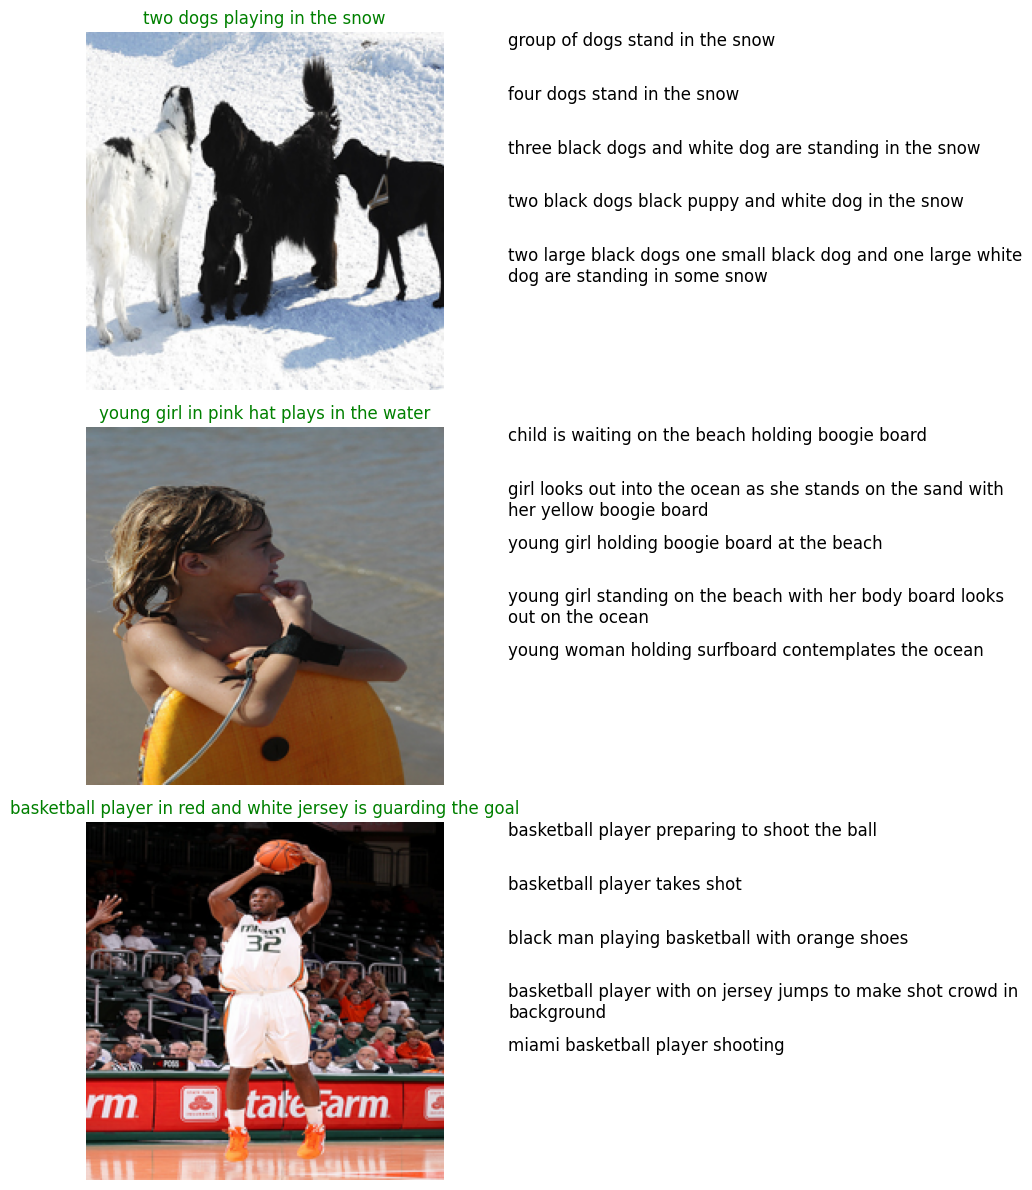

In [72]:
image_size = (224, 224)
num_of_images = 3
count = 1

fig = plt.figure(figsize=(10, num_of_images * 4))

# suffle test_imgs
test_imgs = np.random.permutation(test_imgs)
for i, img_name in enumerate(test_imgs[:num_of_images]):
    # Load the image and features
    img_path = os.path.join('flickr8k_dataset/Flicker8k_Dataset', img_name)
    img_features = extract_features(img_path)
    image_load = Image.open(img_path).resize(image_size)

    # Generate caption and retrieve actual captions
    generated_caption = generate_caption(model, tokenizer, img_features, max_caption_length)
    actual_captions = test_dict.get(img_name, [])
    actual_captions = [caption.replace('startseq ', '').replace(' endseq', '') for caption in actual_captions]

    # Plot the image
    ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    ax.set_title(f"{generated_caption}\n", fontsize=12, color='green', wrap=True)
    ax.axis("off")
    count += 1

    # Plot the actual captions
    ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
    ax.axis("off")
    for j, caption in enumerate(actual_captions):
        ax.text(0.1, 1 - (j * 0.15), caption, fontsize=12, wrap=True, ha='left', va='top')
    count += 1

# Adjust layout and display
plt.tight_layout()
plt.show()


### **Evaluation**

Our key metric is **BLUE SCORE**. 

The BLEU score calculates the precision of n-grams between the generated text (hypothesis) and the reference texts. The BLEU score ranges from 0 to 1, where 1 indicates a perfect match with the reference text.  

A important concept here is **Precision** which represents the ratio of the number of matching n-grams to the total number of n-grams in the hypothesis for that n-gram length. The **overall BLEU score** is a weighted geometric mean of the n-gram precisions.

The weights parameter in the BLEU score function specifies the importance (weight) assigned to each n-gram precision when calculating the overall BLEU score. Weights are a tuple of four values, corresponding to the n-gram precisions from unigram to 4-gram. For example, weights (1.0, 0, 0, 0) mean that only unigram precision is considered. Bigrams, trigrams, and 4-grams are ignored. Then, adjusting the weights allows you to focus the BLEU score on different aspects of the generated text.

In [64]:
def compute_bleu_scores(generated_caption, actual_captions):
    # Tokenize captions
    generated_caption_tokens = word_tokenize(generated_caption.lower())
    actual_captions_tokens = [word_tokenize(caption.lower()) for caption in actual_captions]

    # Define smoothing function to handle short sentences
    chencherry = SmoothingFunction()

    # Compute BLEU-1 to BLEU-4 scores
    bleu_scores = {}
    weights_list = [
        (1.0, 0, 0, 0),
        (0.5, 0.5, 0, 0),
        (0.33, 0.33, 0.33, 0),
        (0.25, 0.25, 0.25, 0.25)
    ]
    for i, weights in enumerate(weights_list, start=1):
        score = sentence_bleu(
            actual_captions_tokens,
            generated_caption_tokens,
            weights=weights,
            smoothing_function=chencherry.method1
        )
        bleu_scores[f'BLEU-{i}'] = score

    # Print BLEU scores
    for key, value in bleu_scores.items():
        print(f"{key} Score: {value:.4f}")

# Example usage
compute_bleu_scores(generated_caption, actual_captions)


BLEU-1 Score: 0.1515
BLEU-2 Score: 0.0973
BLEU-3 Score: 0.0692
BLEU-4 Score: 0.0318


In [73]:
# Compute BLEU Scores for multiple test images

num_images = 100
all_references = []
all_hypotheses = []

for img_name in test_imgs[:num_images]:

    # Actual captions
    img_path = os.path.join('flickr8k_dataset/Flicker8k_Dataset', img_name)
    actual_captions = test_dict.get(img_name, [])
    actual_captions = [caption.replace('startseq', '').replace('endseq', '').strip() for caption in actual_captions]
    actual_captions_tokens = [word_tokenize(caption.lower()) for caption in actual_captions]
    all_references.append(actual_captions_tokens)

    # Generate caption
    img_features = extract_features(img_path)
    generated_caption = generate_caption(model, tokenizer, img_features, max_caption_length)
    generated_caption_tokens = word_tokenize(generated_caption.lower())
    all_hypotheses.append(generated_caption_tokens)

# Compute corpus-level BLEU scores
from nltk.translate.bleu_score import corpus_bleu

bleu1 = corpus_bleu(all_references, all_hypotheses, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(all_references, all_hypotheses, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(all_references, all_hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(all_references, all_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

print(f"Corpus BLEU-1: {bleu1:.4f}")
print(f"Corpus BLEU-2: {bleu2:.4f}")
print(f"Corpus BLEU-3: {bleu3:.4f}")
print(f"Corpus BLEU-4: {bleu4:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [66]:
# Compute average sentence-level BLEU-1 score
bleu_scores = []
chencherry = SmoothingFunction()

for references, hypothesis in zip(all_references, all_hypotheses):
    score = sentence_bleu(
        references,
        hypothesis,
        weights=(1, 0, 0, 0),
        smoothing_function=chencherry.method1
    )
    bleu_scores.append(score)

average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average Sentence-Level BLEU-1 Score: {average_bleu:.4f}")


Average Sentence-Level BLEU-1 Score: 0.3374


In [67]:
# Compute average sentence-level BLEU-4 score
bleu_scores = []
chencherry = SmoothingFunction()

for references, hypothesis in zip(all_references, all_hypotheses):
    score = sentence_bleu(
        references,
        hypothesis,
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=chencherry.method1
    )
    bleu_scores.append(score)

average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average Sentence-Level BLEU-4 Score: {average_bleu:.4f}")


Average Sentence-Level BLEU-4 Score: 0.0470


### **Conclusion**

First of all, the model employed a relatively simple design, combining image features with captions via concatenation and using LSTMs for sequential processing. While this simplicity makes the model easier to understand and implement, it might limit its capacity to model more complex relationships.

**Performance Analysis**

The BLEU scores indicate the model's effectiveness in generating captions that align with reference captions at different n-gram levels:  
- BLEU-1 (0.3462): The model captures some basic unigram-level word matches, indicating it is able to identify key individual words related to the image  
- BLEU-2 (0.1778): The bigram-level score drops significantly, suggesting limited fluency or difficulty forming coherent short phrases  
- BLEU-3 (0.0868) and BLEU-4 (0.0296): The low scores for trigrams and 4-grams reveal that the model struggles to generate longer, syntactically and semantically accurate sequences  

This simpler architecture performs reasonably well for BLEU-1, which reflects its ability to identify and output individual keywords effectively. However, low BLEU-2 to BLEU-4 scores highlight challenges in generating coherent multi-word phrases or sentences

**Recommendations**

* Introduce attention mechanisms to dynamically focus on specific image features when generating each word.
* Replace or supplement LSTMs with transformer-based architectures
* Use pretrained image encoders to extract richer and more context-aware image features.
* Implement beam search during inference to improve the quality of generated captions by exploring multiple plausible sequences.
* Experiment with alternative loss functions or reinforcement learning to directly optimize for caption quality metrics.

This model provides a simple and functional starting point for image captioning. However, its performance, particularly on BLEU-2 and beyond, suggests the need for improvements in handling sequential dependencies and focusing on relevant image features